# Manual ground truth

In [1]:
%matplotlib inline

import hyperspy as hs
import pyxem as px
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from skimage import restoration
from matplotlib.colors import LogNorm

from numpy import log10

from scipy.ndimage import binary_fill_holes, label
from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

from skimage.feature import peak_local_max
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from skimage.filters import sobel, threshold_triangle, threshold_li

## Load dataset

In [2]:
signal = hs.io.load('SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed_crop100.hdf5')
DP_scale = signal.axes_manager[2].scale
DP_scale

0.01904

## Create ground truth from manual virtual dark field analysis

#### Make Precipitate object

In [3]:
from scipy.ndimage import label
import copy

#Creating empty dataset for variables in Precipitates() and also combined ground truth map eventually
empty_vdf = signal.get_integrated_intensity(hs.roi.CircleROI(cx=0, cy=0, r=0.5)).data.copy()
empty_vdf[empty_vdf > 0] = 0 

class Precipitate():
    name = ""
    th = 0
    roi = hs.roi.CircleROI(cx=0, cy=0, r=0, r_inner=0)
    roi2 = hs.roi.CircleROI(cx=0, cy=0, r=0, r_inner=0)
    label_th = 0
    vdf = empty_vdf.copy()
    vdf_mask = empty_vdf.copy()
    label, _ = label(vdf_mask)

    def __init__(self, name, th, label_th, roi):
        self.name = name
        self.th = th
        self.roi = roi
        self.label_th = label_th

def make_precip(name, th, label_th, roi):
    precipitate = Precipitate(name, th, label_th, roi)
    return precipitate
def make_precip2(name, th, label_th, roi, roi2):
    precipitate = Precipitate(name, th, label_th, roi)
    precipitate.roi2 = roi2
    return precipitate

In [4]:
#In plane theta'. Used two reflections for better signal 
roi_thetaPrimes = hs.roi.CircleROI(cx=-0.114238, cy=0.323675, r=0.0475943, r_inner=0)
roi_thetaPrimes2 = hs.roi.CircleROI(cx=0.323675, cy=0.0761587, r=0.0475943, r_inner=0)

#fat horizontals (T1)
roi_h = hs.roi.CircleROI(cx=-0.47124, cy=-0.14756, r=0.02856, r_inner=0)

#fat verticals (T1)
roi_v = hs.roi.CircleROI(cx=0.119, cy=-0.47124, r=0.02856, r_inner=0)

#left angled (thetaPrime, (200)_[010])
roi_la = hs.roi.CircleROI(cx=0.2142, cy=0.13804, r=0.0476, r_inner=0)

#right angled (thetaPrime, (020)_[100])
roi_ra = hs.roi.CircleROI(cx=0.13328, cy=-0.2856, r=0.0476, r_inner=0)

#--------------------------------------------------------------------------------------------#
#       inputs        |      name       |  th, | label_th,|      roi,     |     roi2         #
#--------------------------------------------------------------------------------------------#
Theta_3 =make_precip2("Theta, in-plane", 0.2,      782,    roi_thetaPrimes, roi_thetaPrimes2)#
T1_1    = Precipitate("T1, horizontal",  0.0138,    28,          roi_h )                     #
T1_2    = Precipitate("T1, vertical",    0.014,     28,          roi_v )                     #
Theta_1 = Precipitate("Theta, lefty",    0.12,       7,          roi_la)                     #
Theta_2 = Precipitate("Theta, righty",   0.17,       5,          roi_ra)                     #
#--------------------------------------------------------------------------------------------#

#list:
precips   = np.asarray([Theta_3, T1_1, T1_2, Theta_1, Theta_2])
numbering = np.asarray([   2,     3,     3,     1,       1   ])

In [5]:
for precip in precips:
    if (precip.name != "Theta, in-plane"): #in plane theta use two rois
        precip.vdf = signal.get_integrated_intensity(precip.roi)
    else:
        precip.vdf = signal.get_integrated_intensity(precip.roi) + signal.get_integrated_intensity(precip.roi2)

#### Create masks where you remove everything below certain threshold

In [6]:
for i, precip in enumerate(precips):
    if (precip.name != "Theta, in-plane"):
        vdf_mask = precip.vdf.data.copy()
        vdf_mask[vdf_mask < precip.th] = 0
        vdf_mask[vdf_mask > 0 ] = numbering[i]
        precip.vdf_mask = vdf_mask

    else:
        ### Need to remove edge on theta from in plane theta:
        vdf_mask_la = precips[3].vdf.data.copy()
        vdf_mask_la[vdf_mask_la < precips[3].th] = 0 # 3= left angle theta needles (see parameters for precips)
        vdf_mask_la[vdf_mask_la > 0] = 1

        vdf_mask_ra = precips[4].vdf.data.copy()
        vdf_mask_ra[vdf_mask_ra < precips[4].th] = 0 # 4 = righ angle theta needles
        vdf_mask_ra[vdf_mask_ra > 0] = 1

        #Adding unwanted thetas to one mask and setting any potential 2 = 1
        combined_mask = vdf_mask_la + vdf_mask_ra
        combined_mask[combined_mask > 0] = 1 # All needle pix should be 1
        #### ----- ###

        vdf_mask = precip.vdf.data.copy()
        vdf_mask[vdf_mask < precip.th] = 0
        vdf_mask[vdf_mask > 0 ] = numbering[i]

        # Removing other oriientations from map
        vdf_mask[vdf_mask == combined_mask*2] = 0
        precip.vdf_mask = vdf_mask

#### Use label from scipy to remove noise

In [7]:
from scipy.ndimage import label

for precip in precips:
    # Labels groups of pixels by size
    precip.label = label(precip.vdf_mask)[0]
    for i in np.arange(1, np.max(precip.label)):
        # Everything below label_th size concidered noise and removed:
        if np.sum(precip.label[precip.label == i])/i < precip.label_th: 
            precip.vdf_mask[precip.label == i] = 0

#### Now combine all masks to ground truth

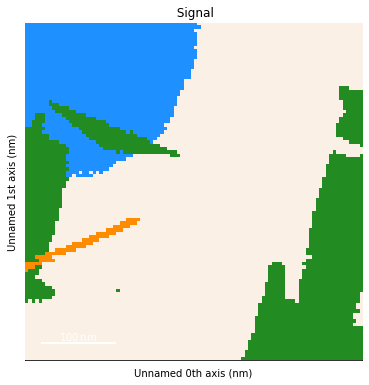

In [8]:
ground_truth = empty_vdf.copy()

for i, precip in enumerate(precips):
    precip = precip
    ground_truth[precip.vdf_mask == numbering[i]] = numbering[i]

ground_truth = hs.signals.BaseSignal(ground_truth)
ground_truth.axes_manager[0].scale = 4.63
ground_truth.axes_manager[1].scale = 4.63
ground_truth.axes_manager[0].units = 'nm'
ground_truth.axes_manager[1].units = 'nm'

from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

color_names = ['linen', 'darkorange', 'dodgerblue', 'forestgreen']
colors = [to_rgba(c) for c in color_names]

cmap = LinearSegmentedColormap.from_list('gt_cmap', colors, N=len(color_names))

ground_truth.plot(cmap=cmap, colorbar=False)